In [1]:
using Pkg
Pkg.activate("../Project.toml")

using ITensors
using Plots
using Random
using Interpolations
using LegendrePolynomials
using Distributions
# using ClassicalOrthogonalPolynomials
using Integrals
using KernelDensity
include("RealRealHighDimension.jl")


  Activating project at `~/Documents/QML Project/QuantumInspiredML`


fitMPS

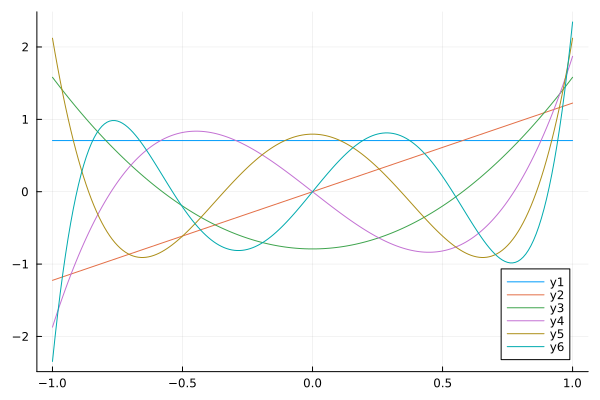

In [5]:
xs = collect(-1:0.01:1)

ys = (Pl.(xs, 0; norm = Val(:normalized)))
p = plot(xs, ys)
for i in 1:5
    ys =(Pl.(xs, i; norm = Val(:normalized)))
    plot!(p,xs, ys)
end
p

In [6]:
all([Pl(1,i; norm=Val(:normalized)) for i in 1:1000] .>= 0 )

true

In [39]:
encoding = legendre()
dloc =  "../Data/ecg200/datasets/ecg200.jld2"
f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)

scaler = fit_scaler(RobustSigmoidTransform, X_train);
erange = encoding.range
X_train_scaled = transform_data(scaler, X_train; range=erange)

X_test_scaled = transform_data(scaler, X_test; range=erange);

In [40]:
@show size(X_train_scaled), length(y_train)

(size(X_train_scaled), length(y_train)) = ((100, 96), 100)


((100, 96), 100)

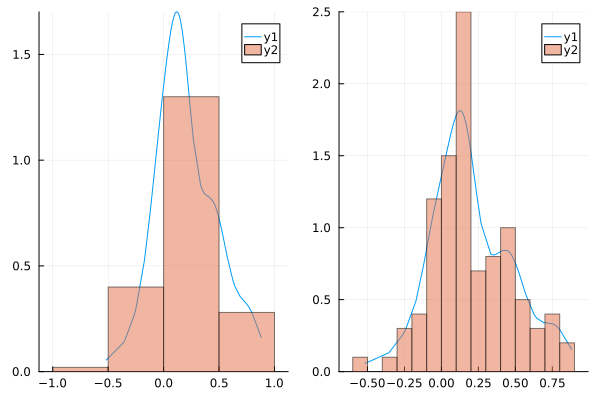

In [42]:
xs1 = sort(X_train_scaled[:,1])

kdense1_1 = kde(xs1;)
kdense1_2 = kde(xs1; bandwidth=0.08)




ys1_1 = pdf(kdense1_1, xs1)
ys1_2 = pdf(kdense1_2, xs1)



p1_1 = plot(xs1, ys1_1)
histogram!(p1_1, xs1, alpha=0.5, norm=:pdf, bins=6)

p1_2= plot(xs1, ys1_2)
histogram!(p1_2, xs1, alpha=0.5, norm=:pdf, bins=15)



plot(p1_1,p1_2;)

In [43]:
size(mean(X_train_scaled; dims=1))

(1, 96)

In [44]:
xsd = sort(mean(X_train_scaled; dims=1)[:])
kdense = kde(xsd; bandwidth=0.08)
xs = range(-1,1,200)
ys = pdf(kdense, xs)

wf = sqrt.(ys);

In [73]:
d = 20
nterms = 10*d

legfuncs = []
expansion = []
for i in 0:nterms-1
    ysi = Pl.(xs, i; norm = Val(:normalized))
    push!(legfuncs, ysi)
    problem = SampledIntegralProblem(wf .* ysi, xs)
    method = TrapezoidalRule()
    push!(expansion, solve(problem, method).u)
end

ysexp = zeros(length(ys))
ysappr = zeros(length(ys))

for i in 1:d

    ysexp .+= expansion[i] .* legfuncs[i]

end

coeffs = partialsortperm(abs2.(expansion), 1:d; rev=true)

for i in coeffs

    ysappr .+= expansion[i] .* legfuncs[i]

end


scatter(xs, wf; label="True")
#scatter!(xs, ysexp; label="Series")
scatter!(xs, ysexp; label="Expansion")
scatter!(xs, ysappr; label="weighted Expansion")


DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 200 and 100

In [48]:
partialsortperm(abs2.(expansion), 1:d; rev=true)




8-element view(::Vector{Int64}, 1:8) with eltype Int64:
  1
  3
  7
  9
  2
  6
 11
  5

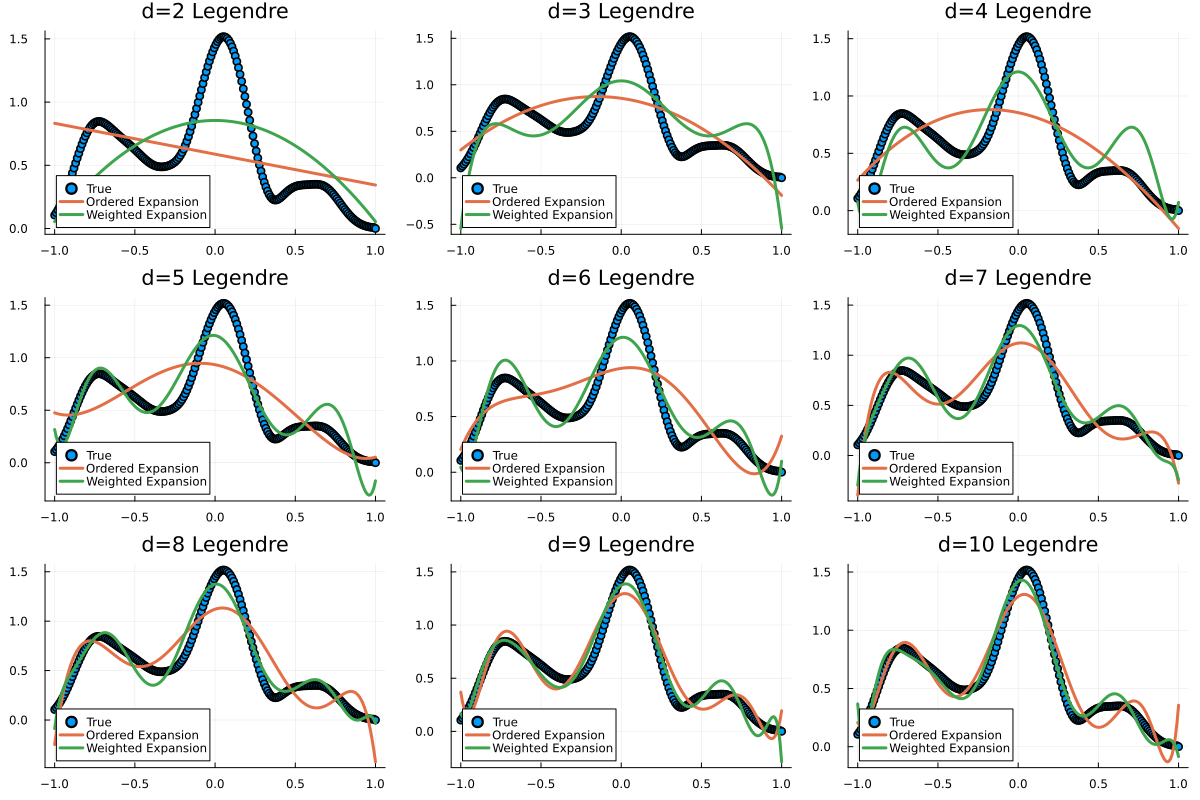

In [58]:
d = 8
nterms = 50#100*d

legfuncs = []
expansion = []
f = (x,l) -> Pl(x, l; norm=Val(:normalized))
for i in 0:nterms-1
    ysi = f.(xs, i)
    push!(legfuncs, ysi)
    problem = SampledIntegralProblem(wf .* ysi, xs)
    method = TrapezoidalRule()
    push!(expansion, solve(problem, method).u)
end

ysexp = zeros(length(ys))


# for (i,w) in enumerate(expansion)

#     ysexp .+= w .* legfuncs[i]

# end
ps = []
coeffs = []
for d in 2:10
    ysappr = zeros(length(ys))
    coeffs = partialsortperm(abs2.(expansion), 1:d; rev=true)

    for i in coeffs

        ysappr .+= expansion[i] .* legfuncs[i]

    end

    ysexp = zeros(length(ys))

    for i in 1:d

        ysexp .+= expansion[i] .* legfuncs[i]

    end



    p = scatter(xs, wf; label="True", title="d=$d Legendre", legend=:bottomleft)
    plot!(p, xs, ysexp; label="Ordered Expansion", linewidth=3)
    plot!(p, xs, ysappr; label="Weighted Expansion", linewidth=3)
    push!(ps,p)
end

plot(ps..., size=(1200,800))


In [59]:
coeffs

10-element view(::Vector{Int64}, 1:10) with eltype Int64:
  1
  3
  7
  9
  2
  6
 11
  5
 12
 13

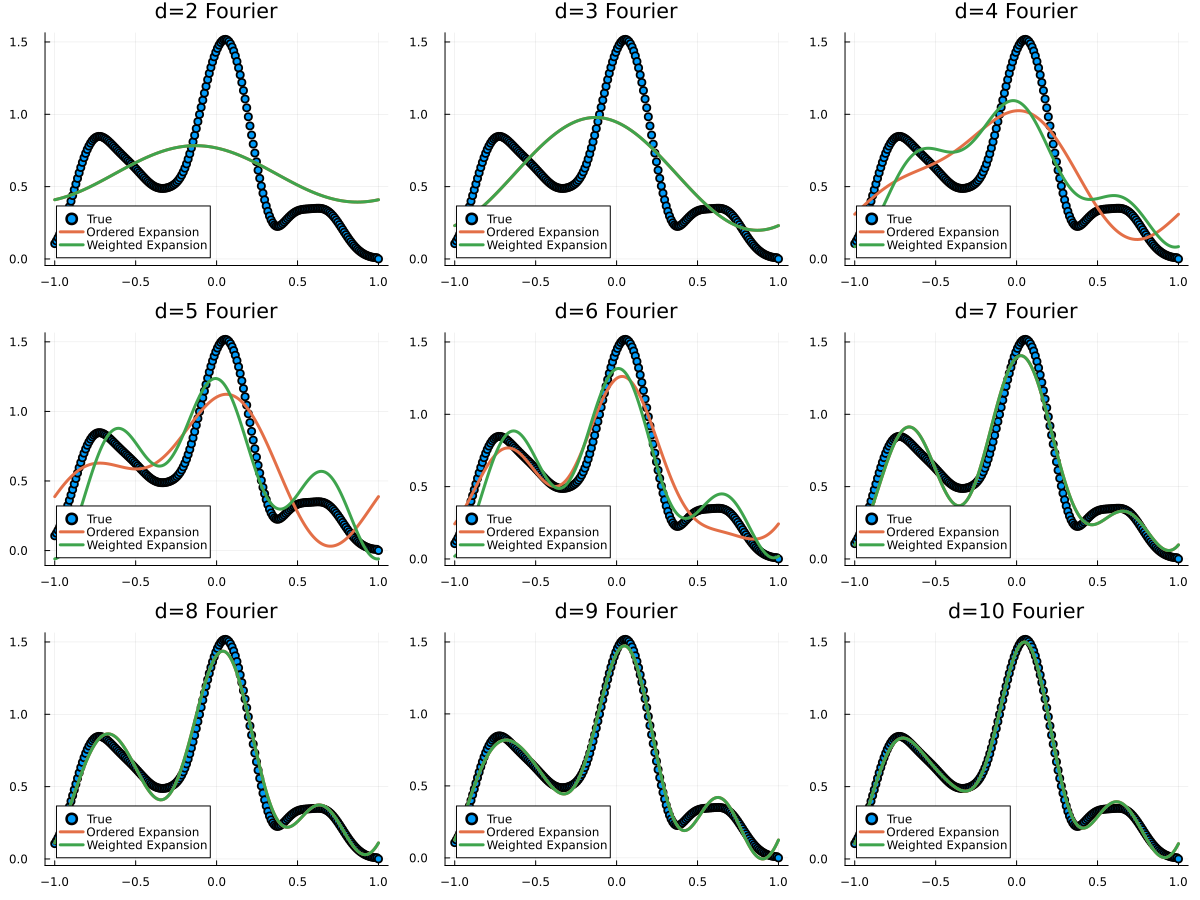

In [51]:
# Fourier

d = 8

nterms = 10*d
freqs = get_fourier_freqs(nterms)

legfuncs = []
expansion = []
f = (x,l) -> cispi.(x * freqs[l+1])
for i in 0:nterms-1
    ysi = f.(xs, i)
    push!(legfuncs, ysi)
    problem = SampledIntegralProblem(wf .* conj.(ysi), xs)
    method = TrapezoidalRule()
    push!(expansion, 0.5*solve(problem, method).u)
end





ps = []
for d in 2:10
    ysappr = zeros(ComplexF64,length(ys))
    inds = partialsortperm(abs2.(expansion), 1:d; rev=true)

    for i in inds

        ysappr .+= expansion[i] .* legfuncs[i]

    end

    ysexp = zeros(ComplexF64, length(ys))

    for i in 1:d
        
        ysexp .+= expansion[i] .* legfuncs[i]

    end



    p = scatter(xs, wf; label="True", title="d=$d Fourier", legend=:bottomleft)
    plot!(p, xs, real.(ysexp); label="Ordered Expansion", linewidth=3)
    plot!(p, xs, real.(ysappr); label="Weighted Expansion", linewidth=3)
    push!(ps,p)
end

plot(ps..., size=(1200,900))


In [70]:
function enc_error_seq(x, x0, n)
    out = 0.
    for i in 1:n
        out += Pl(x, i; norm=Val(:normalized)) * Pl(x0, i; norm=Val(:normalized))
    end
    return out
end

function enc_error_exp(x, x0, n; order=coeffs)
    out = 0.
    for i in 1:n
        l = order[i]
        out += Pl(x, l; norm=Val(:normalized)) * Pl(x0, l; norm=Val(:normalized))
    end
    return out
end

enc_error_exp (generic function with 1 method)

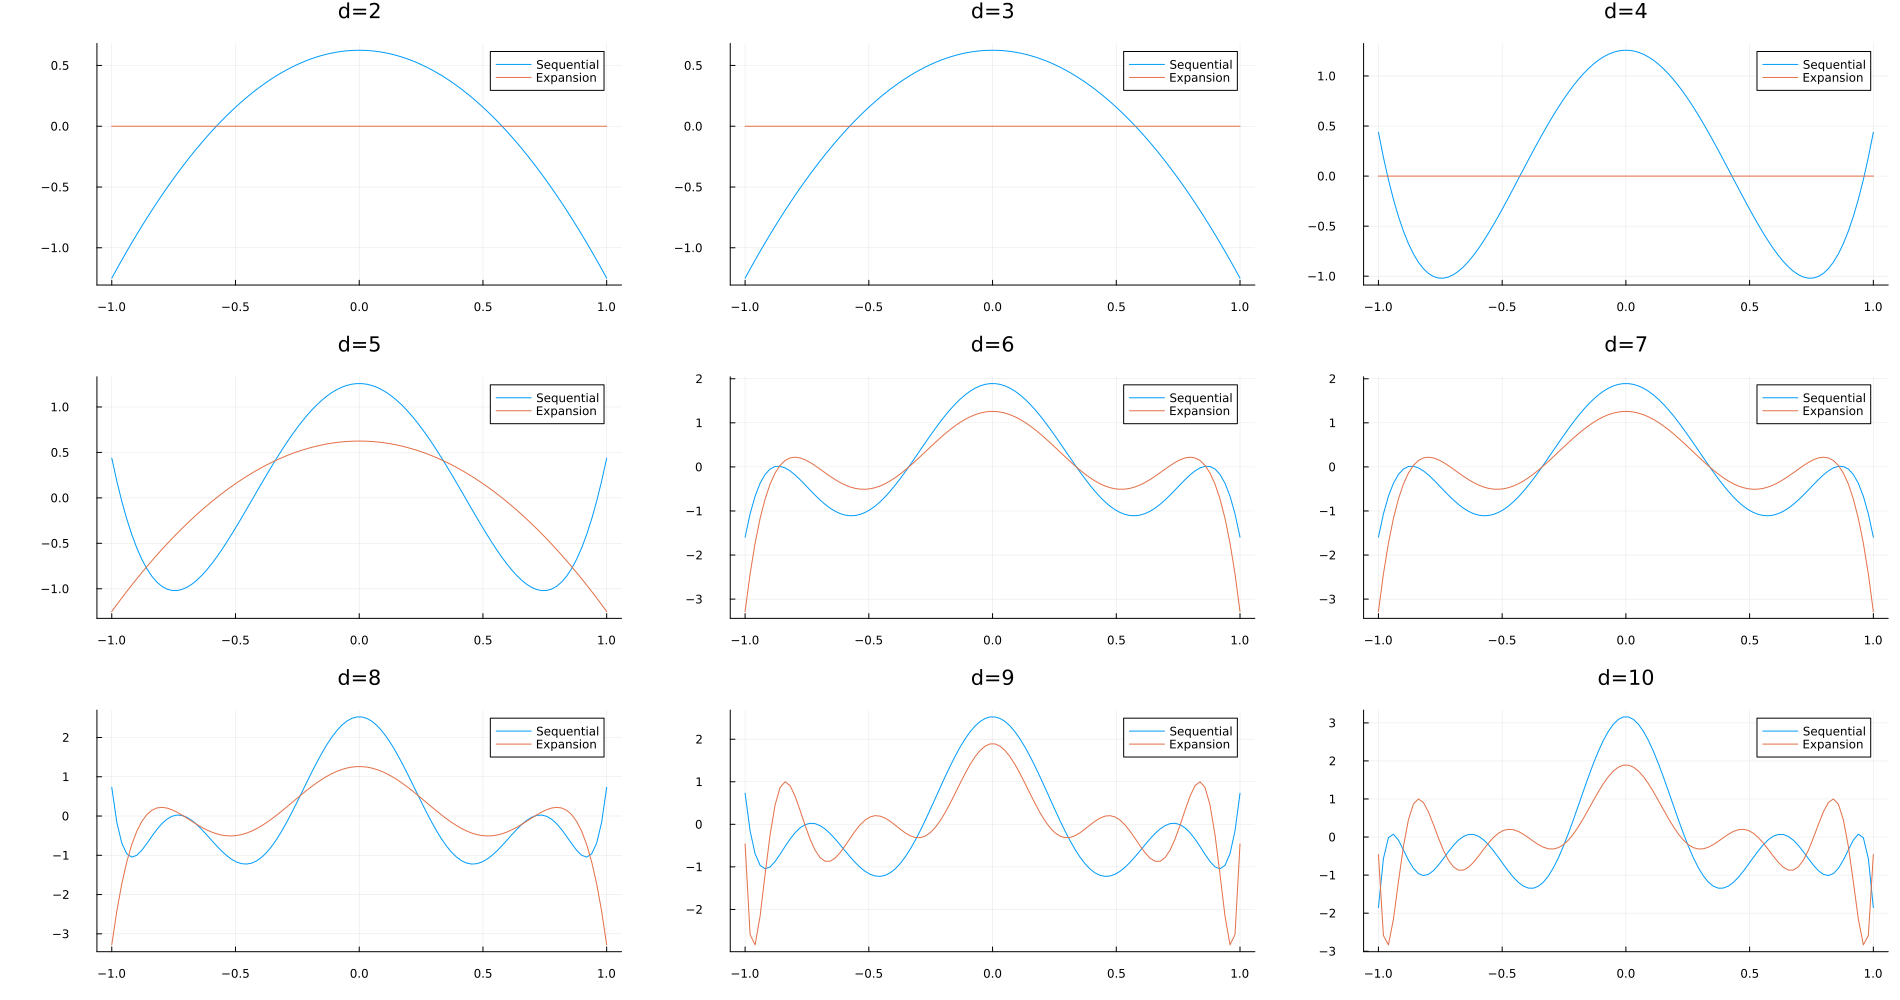

In [71]:
order = 2:10
xs = range(-1,1,100) |> collect
x0 = 0
ps = []

for n in order
    plot(xs, map(x->enc_error_seq(x, x0,n), xs); label="Sequential", title="d=$n")
    p = plot!(xs, map(x->enc_error_exp(x, x0,n), xs); label="Expansion")

    push!(ps,p)
end

plot(ps..., size=(1900,1000), layout=(3,3), bottom_margin=5mm, left_margin=10mm, top_margin=5mm)

In [65]:
ys = map(x->enc_error_seq(x, x0,10), xs)

100-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 ⋮
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing